In [1]:
##Felipe Ixcamparic, 2021- Proyecto de prácticas/Tésis 2021 | USAC-UNAM

In [2]:
!pip install import-ipynb

  Using cached import_ipynb-0.1.3-py3-none-any.whl


In [218]:
pip install numba==0.54

     |████████████████████████████████| 3.5 MB 47 kB/s s eta 0:00:01  | 2.6 MB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 26.3 MB 22 kB/s s eta 0:00:01    |█████████▌                      | 7.8 MB 40.7 MB/s eta 0:00:01     |████████████████                | 13.1 MB 40.7 MB/s eta 0:00:01B 40.7 MB/s eta 0:00:01��████████▍    | 22.5 MB 40.7 MB/s eta 0:00:01
     |████████████████████████████████| 15.4 MB 2.0 kB/s eta 0:00:01 0:00:02��█████          | 10.6 MB 7.4 MB/s eta 0:00:01█████████████████▋   | 13.7 MB 7.4 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.1
    Uninstalling numpy-1.22.1:
      Successfully uninstalled numpy-1.22.1
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.38.0
    Uninstalling llvmlite-0.38.0:
      Successfully uninstalled llvmlite-0.38.0
  Attempting uninstall: numba
    Found existing installation: numba 0.55.0
    Uninstalling numba-0.55.0:
      Successfully uninstall

In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

import numpy as np

# Import Qiskit classes
import qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

#LIBRERÍAS PARA TODO LO NECESARIO: 
#!pip install qiskit ipywidgets    correr esta línea de primero si se trabaja en google collab

#Importación de qiskit
from qiskit import *

%matplotlib inline
from matplotlib import *

#Se importan clases y funciones necesarias para la tomografía
import qiskit.quantum_info as qi
from qiskit.compiler import assemble
import numpy as np 
# from numpy import *

# Librerías estandar de qiskit
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.quantum_info import *
from qiskit.extensions import Initialize
import import_ipynb

#Funciones creadas para generar estados aleatorios
# from qubit_aleatorio import estado_aleatorio_normal
import qubit_aleatorio as al


#Para dibujar sobre la esfera de bloch
# from kaleidoscope import bloch_sphere
#Extración
import scipy
from scipy.stats import lognorm
import scipy.stats as stats
import re 
import collections as colect
import matplotlib.pyplot as plt

ibmqfactory.load_account:WARNING:2022-02-01 04:01:48,675: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
from kaleidoscope import bloch_sphere

In [4]:
def rho_to_cartesian(rho):                            
    """
    Argumento(s): 
    rho: matríz de densidad respectiva a un qubit de 2 dimensiones
    Salida: representación del estado en coordenadas cartesianas sobre la Esfera de Bloch
    """
    #Matrices de Pauli (2 dimensiones)
    S_x=np.array([[0,1],[1,0]])
    S_y=np.array([[0,-1.j],[1.j,0]])
    S_z=np.array([[1,0],[0,-1]])
    
    #Transformación de la matríz de densidad hacia las coordenadas 
    #Sabiendo que que rho= (I + r*sigma)/2
    rx= np.trace(np.matmul(rho,S_x))
    ry= np.trace(np.matmul(rho,S_y))
    rz= np.trace(np.matmul(rho,S_z))
    #Se guardan las posiciones en un vector de numpy
    posicion=np.array([np.real(rx),np.real(ry),np.real(rz)])
    return posicion

# Creación de estados mixtos en computadoras cuánticas: 

El siguiente notebook se enfoca en crear estados mixtos en computadoras cuánticas, ya que no es posible inicializar un ensamble estadístico deseado, es necesario buscar otro tipo de métodos. El siguiente método toma su estructura del paper: https://arxiv.org/pdf/2001.02552.pdf. Como también unos conceptos del paper:  https://arxiv.org/pdf/1905.10876.pdf. 

## Ansatz:
Es un circuito parametrizado por una rotación unitaria U(θ), usada para preparar un estado deseado de la forma $|Ψ(θ)⟩=U(θ)|e_0>$. 

Buscamos realizar esta parametrización en el siguiente circuito, consistiendo de n_qubits para el sistema y n_qubits para el entorno, trazando parcialmente el entorno para obtener la matriz densidad del sistema. 

Buscamos entonces $ρ(θ)$, donde $\vec{ θ}$ es un vector de rotaciones implementadas en cada compuerta del Ansatz.


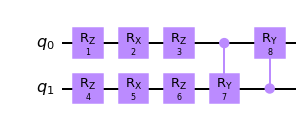

In [5]:
#Inicializacion de un estado mixto en una CC: 

#Creando el Ansatz:
def cirq_ansq(qubits,parameters,layers):
    '''
    Generador de ansatz para un sistema cerrado (sistema-entorno). 
    
    Entradas:
    --------------
        qubits:int
            número de qubits correspondiente a la dimension de la matriz densidad a generar.
        parameters: float-array
            vector de parámetros theta, correspondiente a las rotaciones a realizar en el circuito. 
            **Se necesitan 8*qubits*capas parámetros. 
        layers: int 
            número de capas a utilizar en el circuito para generar la matriz densidad. 
    
    Salidas: 
    ------------
        ansq: Objeto tipo quantum circuit
            Circuito cuántico generado
        rho_sist: Objet tipo DensityMatrix
            Matriz densidad del sistema, tras trazar parcialmente el entorno. 
    
    '''
    #Se genera un circutio de 2n qubits (la mitad para la matriz densidad, la otra para los qubits de entorno). 
    ansq=QuantumCircuit(2*qubits)
    
    #Se aplican por capas las rotaciones correspondientes indicadas en el paper de referencia. 
    for j in range(layers):
        for i in range(2*qubits): 
#             ansq.rx(parameters[0],i)
#             parameters= np.delete(parameters,0)
#             ansq.rz(parameters[0],i)
#             parameters= np.delete(parameters,0)
            
            
            ansq.rz(parameters[0],i)
            parameters= np.delete(parameters,0)
            ansq.rx(parameters[0],i)
            parameters= np.delete(parameters,0)
            ansq.rz(parameters[0],i)
            parameters= np.delete(parameters,0)
    
    #Se completa con compuertas cry para dar intereacción entre los qubits. 
    for w in range(2*qubits-1):

        
        ansq.cry(parameters[0],w,w+1)
        parameters= np.delete(parameters,0)     
        if w==(2*qubits-2):
            ansq.cry(parameters[0],w+1,0)
            parameters= np.delete(parameters,0)
        
        '''
        Descomentar abajo y comentar el bloque de arriba
        para usar CB anzats (ref: https://arxiv.org/pdf/1905.10876.pdf).
        '''
    
        # ansq.crx(parameters[0],w,w+1)
        # parameters= np.delete(parameters,0)     
        # if w==(2*qubits-2):
        #     ansq.crx(parameters[0],w+1,0)
        #     parameters= np.delete(parameters,0)
    

    
    #Se guarda en un vector los qubits de entorno a ser trazados. 
    ancilla=[]
    for k in range(qubits,2*qubits):
        ancilla.append(k)
    
    rho_sist=qi.partial_trace(qi.DensityMatrix(ansq),ancilla)
    
    return ansq, rho_sist

#La función puede ser probada claro, se necesitan
circ= cirq_ansq(qubits=1,parameters=np.linspace(1,35,35),layers=1)
circ[0].draw()

## Función de Costo: 
Una función de costo suele ser asociada a un valor con cada posible solución a un problema en orden de elegir el más óptimo, en la mayoría de casos se busca minimizar esta función.    (ref: https://docs.microsoft.com/en-us/azure/quantum/optimization-concepts-cost-functions) 

Nuestro objetivo es hallar una función de costo que optimice nuestros parámetros theta de tal forma que correspondan a la matriz densidad que buscamos.
Para ello definimos nuestra función de costo como la fidelidad entre el estado objetivo y la matriz densidad obtenida del circuito anterior. 

$C(\theta) = Fidelidad(\rho(\theta),\rho_{target})$

In [6]:
target=[[1/2,0],[0,1/2]]  #Matriz densidad objetivo
cost_por_iteracion=[]    #Almacenamiento la fidelidad en cada iteracion

def cost_func(params):
    '''
    Función de costo para hallar la matriz densidad objetivo. 
    
    Entradas:
        Globales: 
            qubits: int
                número de qubits a usar en el circuito. 
            layers: int
                número de capas a usar en el circuito. 
            target: array, float
                matriz densidad objetivo 
        Locales: 
            params:float,array
                parametros theta, correspondientes a las rotaciones a usar. 
    
    '''
    Dens= cirq_ansq(qubits,params,1)[1]
    cost=-qi.state_fidelity(Dens,target)  #Se compara la fidelidad y luego se obtiene el negativo para ser minimizado. 
    cost_por_iteracion.append(cost)
    return cost

Esta función de costo entonces busca ser optimizada para encontrar el vector $\vec{\theta}$ correspondiente a la Fidelidad máxima entre $\rho(\theta)$ y $\rho_{target}$. Para ello se usa el optimizador de scipy, con el método de COBYLLA. 

In [7]:
def minimize(cost_fun,maxitr):
    #Se eligen valores iniciales de 0 a 2-pi ya que es el ángulo máximo posible de rotación. 
    parame2=np.random.rand(8,1)*2*np.pi
    results = scipy.optimize.minimize(cost_fun,parame2,method='COBYLA',options={'maxiter':maxitr}) 
    return results.fun,results.x

In [8]:
'''Proceso de minimización:
     Para este proceso se declaran condiciones iniciales, se minimizan los parámetros theta
     y se encuentran los valores óptimos que coindican con nuestra matriz densidad objetivo. 
'''
#Condiciones iniciales movibles:

qubits=1 #Se designa el número de qubits
capas=1  #Se establece el número de capas
target= qi.random_density_matrix(2)
cost_por_iteracion=[] #Se resetea el vector de iteraciones
maxitr=50  #Número máximo de iteraciones

result=minimize(cost_func,maxitr)

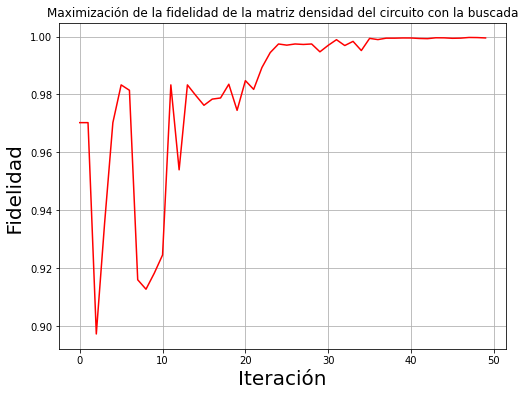

In [9]:
fidel_vals=[]
for i in range(len(cost_por_iteracion)):
    fidel_vals.append(cost_por_iteracion[i]*-1)
fig=plt.figure(figsize=(8, 6))
plt.plot(fidel_vals,'r-')
plt.xlabel("Iteración",size=20)
plt.ylabel(" Fidelidad  ",size=20)
plt.title("Maximización de la fidelidad de la matriz densidad del circuito con la buscada")
plt.grid() 
plt.savefig('iteraciones.png')
fig.show()    

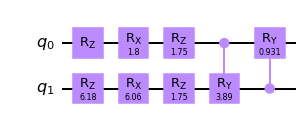

In [10]:
#Con los parámetros óptimos se puede ver que circuito en efecto genera esta matriz densidad

cirq_ansq(1,result[1],1)[0].draw()

In [11]:
cirq_ansq(1,result[1],1)[1].draw('latex')

<IPython.core.display.Latex object>

In [12]:
target.draw('latex')

<IPython.core.display.Latex object>

## Uso del circuito en una computadora cuántica: 


Teniendo los parámetros óptimos mediante simulación, entonces ya es posible usarlos en una computadora cuántica, iniciaremos comprobando su fidelidad mediante tomografía de estado

In [13]:
def state_tomo(n_shots,circuito,qubits,server=None):
    '''
    Función para ejecutar tomografía de estado cuántico sobre un circuito cuántico 
    
    Entradas: 
        n_shots: int
            número de tiros para las corridas. 
        circuito: QuantumCircuit
            Circuito cuántico para realizar el proceso de tomografía
        qubits: int
            Número de qubits para realizarle el proceso de tomografía
        server: int
            0 --> Se ejecuta en el simulador
            1---> Se ejecuta en una computadora cuántica.
            Por defecto estará en 0 si no se llena el campo , siendo en un simulador. 
    
    Salidas:
        rho_fit: Objeto DensityMatrix.
            Matriz densidad obtenida tras el proceso de tomografía de estado. 
    '''
    
    #Se guarda en un vector los qubits a trazar. 
    obtain=[]
    for i in range(qubits):
        obtain.append(i)
     
    #Creación de circuitos de tomografía y respectiva ejecución. 
    qst_q0 = state_tomography_circuits(circuito, obtain) 
    
    if server==None or server==0:
        job = qiskit.execute(qst_q0,Aer.get_backend('qasm_simulator'), shots=n_shots)
        job_monitor(job)
        resultado = StateTomographyFitter(job.result(), qst_q0)
        #Obtención de la matriz densidad luego de la tomografía de estado. 
        rho_fit = resultado.fit(method='lstsq')
        rho_fit = qi.DensityMatrix(rho_fit)
        return rho_fit  

    
    elif server==1: 
        job = qiskit.execute(qst_q0,backend=qcomp , shots=n_shots)
        job_monitor(job)
        resultado = StateTomographyFitter(job.result(), qst_q0)
        #Obtención de la matriz densidad luego de la tomografía de estado. 
        rho_fit1 = resultado.fit(method='lstsq')
        rho_fit1 = qi.DensityMatrix(rho_fit1)
        return rho_fit1
    
    else:
        print('Este no es un número válido')

In [14]:
#Se ejecuta el circuito con los parámetros optimizados y se le hace tomografía de estado 
rho_simulation= state_tomo(n_shots= 5000,circuito=cirq_ansq(1,result[1],1)[0] ,qubits=1,server=0)

Job Status: job has successfully run


In [15]:
#Es posible realizar lo mismo en alguna computadora cuántica. 
provider = IBMQ.get_provider('ibm-q')
qcomp= provider.get_backend('ibmq_belem') 

rho_qcomp= state_tomo(3000,cirq_ansq(1,result[1],1)[0],1,1) 

Job Status: job is queued (402)   

KeyboardInterrupt: 

In [15]:
Fidelidad_simu = qi.state_fidelity(target,rho_simulation)
Fidelidad_qcomp = qi.state_fidelity(target,rho_qcomp)

print('Matriz densidad objetivo' + str(target))
print('Fidelidad con simulación: '+str(Fidelidad_simu))
print('Fidelidad con q_comp: '  + str(Fidelidad_qcomp)) 

Traceback (most recent call last):
  File "/tmp/ipykernel_60/3994490122.py", line 2, in <module>
    Fidelidad_qcomp = qi.state_fidelity(target,rho_qcomp)
NameError: name 'rho_qcomp' is not defined

Use %tb to get the full traceback.


In [16]:
Fidelidad_simu = qi.state_fidelity(target,rho_simulation)

print('Matriz densidad objetivo' + str(target))
print('Fidelidad con simulación: '+str(Fidelidad_simu))

Matriz densidad objetivoDensityMatrix([[ 0.53200952+0.j        , -0.38442535-0.00011952j],
               [-0.38442535+0.00011952j,  0.46799048+0.j        ]],
              dims=(2,))
Fidelidad con simulación: 0.9997303521385895


## Extracción del dataset

In [25]:
'''
Extracción de dataset con estados mixtos: 


    Basta con mover las condiciones iniciales para la extracción del dataset. La complejidad
    computacional no ha sido tomada aún para este proceso, por lo que se recomienda paciencia mas que todo
    y RAM. 
    

'''


##Con todo lo anterior es relativamente sencillo extraer un dataset, para ello abriremos archivos de texto:

#===================================================================================================

#Condiciones iniciales
num=99     #Número de datos a extraer
maxitr=60   #Número de iteraciones en cada minimización
qubits=1    # Número de qubits
layers=1     #Número de capas

#====================================================================================================

#Es posible realizar lo mismo en alguna computadora cuántica. 
provider = IBMQ.get_provider('ibm-q')
qcomp= provider.get_backend('ibmq_belem') 
#=====================================================================================================

#nombre de archivos de texto
targ_name='targets2.npy'
results_name='results2.npy'
fidelity_name='fielities2.npy'
#=========================================================================================================

#Apertura de archivos de texto
f1 = open(targ_name, "w")
f2 = open(results_name,"w")
f3 = open(fidelity_name,"w")



#Proceso de guardado en archivo
targvals=0
densvals=0
fidels=0


target = qi.random_density_matrix(2).__array__()
targvals=target

dens,params=minimize(cost_func,maxitr)

densvals= state_tomo(3000,cirq_ansq(1,params,1)[0],1,1).__array__() 

fidels=qi.state_fidelity(qi.DensityMatrix(target),qi.DensityMatrix(densvals))


for i in range(0,num):
    print('Corrida numero'+str(i))
    
    target = qi.random_density_matrix(2).__array__()
    targvals= np.append(targvals,target)    
            
        
    
    dens,params=minimize(cost_func,maxitr)

    densvals= np.append(densvals,state_tomo(3000,cirq_ansq(1,params,1)[0],1,1).__array__())
    fidels = np.append(fidels,  qi.state_fidelity( qi.DensityMatrix(target) , state_tomo(3000,cirq_ansq(1,params,1)[0],1,1)) )


np.save(targ_name,targvals)
np.save(results_name,densvals)
np.save(fidelity_name,fidels)
f1.close()
f2.close()
f3.close()

Job Status: job has successfully run
Corrida numero0
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero1
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero2
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero3
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero4
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero5
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero6
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero7
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero8
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero9
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero10
Job Status: job has successfully run
Job Statu

# Analisis de Resultados

In [17]:
fidels1=np.load('fielities.npy')
targvals1=np.load('targets.npy')
densvals1=np.load('results.npy')

fidels2=np.load('fielities2.npy')
targvals2=np.load('targets2.npy')
densvals2=np.load('results2.npy')


targvals=np.concatenate((targvals1,targvals2))
fidels=np.concatenate((fidels1,fidels2))
densvals=np.concatenate((densvals1,densvals2))

In [18]:
print("La media de fidelidad con los estados mixtos buscados es de " + str(np.median(fidels)) + " con una desviación estándar de " + str(np.std(fidels)) )

La media de fidelidad con los estados mixtos buscados es de 0.9856767179169414 con una desviación estándar de 0.017959560598241397


In [177]:
#Extracción y reshape de datos

rho00_targ=[]
rho01_targ=[]
rho10_targ=[]
rho11_targ=[]

rho00_res=[]
rho01_res=[]
rho10_res=[]
rho11_res=[]
for i in range(0,len(densvals),4):
    rho00_targ.append(targvals[i])
    rho00_res.append(densvals[i])
    
    rho01_targ.append(targvals[i+1])
    rho01_res.append(densvals[i+1])
    
    rho10_targ.append(targvals[i+2])
    rho10_res.append(densvals[i+2])
    
    rho11_targ.append(targvals[i+3])
    rho11_res.append(densvals[i+3])



tar=[]
tarcol=[]
res=[]
rescol=[]
x_res=[]
x_mix=[]
y_res=[]
y_mix=[]
z_res=[]
z_mix=[]


for i in range(0,len(densvals),4):
    tar.append(rho_to_cartesian((np.reshape(targvals[i:i+4],(2,2)))) )
    res.append(rho_to_cartesian((np.reshape(densvals[i:i+4],(2,2)))) )

for i in range(0,len(tar)):
    x_mix.append(tar[i][0])
    y_mix.append(tar[i][1])
    z_mix.append(tar[i][2])
    x_res.append(res[i][0])
    y_res.append(res[i][1])
    z_res.append(res[i][2])
for i in range(0,len(fidels)):
    if fidels[i]<=0.5:
        tarcol.append('ff0612')
    elif fidels[i]<=0.6 and  fidels[i]>0.5 :
        tarcol.append('ff7200')
    elif fidels[i]<=0.7 and  fidels[i]>0.6 :
        tarcol.append('ffcc00')
    elif fidels[i]<=0.8 and  fidels[i]>0.7 :
        tarcol.append('9cff00')
    elif fidels[i]<=0.9 and  fidels[i]>0.8 :
        tarcol.append('00ffba')
    elif fidels[i]<=0.95 and  fidels[i]>0.9 :
        tarcol.append('00baff')
    elif fidels[i]<=1.00 and  fidels[i]>0.95 :
        tarcol.append('000cff')
        
aux0=[]
aux1=[]
aux2=[]
aux00=[]
aux01=[]
aux02=[]

for i in range(0,len(densvals),4):
    aux0=[]
    aux00=[]
    for j in range(4):
        # aux0=[]
        # aux00=[]
        
        aux00.append(targvals[i+j])
        aux0.append(densvals[i+j])
        
    aux01.append(aux00)
    aux1.append(aux0)        
        
        

aux01=np.array(aux01)
aux1=np.array(aux1)


for i in range(0,len(aux1)):
    aux2.append(np.reshape(aux1[i],(2,2)))
    aux02.append(np.reshape(aux01[i],(2,2)))
    
n_fidels=[]    
for i in range(len(fidels)): 
    n_fidels.append(qi.state_fidelity(aux02[i],aux2[i]))

In [178]:
def trace_dist(sigma,rho):
    """ Encuentra la trace distance entre 2 matrices densidad correspondientes a estados de qubits"""
    return np.real(np.trace( np.sqrt( np.matmul( np.conjugate(np.transpose(sigma-rho)), (sigma-rho)  )  )      )/2 )

trace_vals=[]
for i in range(len(aux2)):
    trace_vals.append(trace_dist(aux02[i],aux2[i]))

In [179]:
print("Se presentan distancias promedio de " + str( np.mean(trace_vals) ) +" con desviación estándar de " + str(np.std(trace_vals) ))

Se presentan distancias promedio de 0.0933551969670194 con desviación estándar de 0.04311687285422814


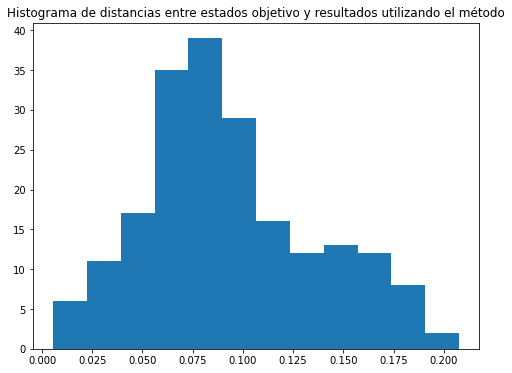

In [289]:
fig=plt.figure(figsize=(8, 6))
plt.hist(trace_vals,bins=12)
plt.title('Histograma de distancias entre estados objetivo y resultados utilizando el método')
fig.savefig('datos.png')


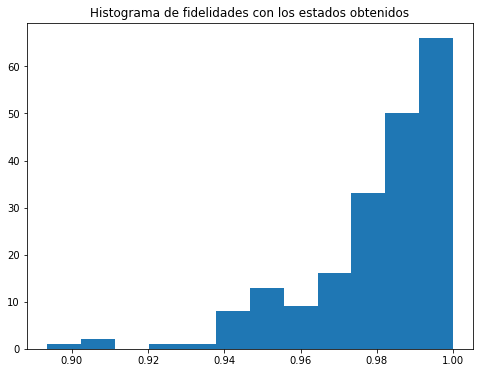

In [283]:
fig=plt.figure(figsize=(8, 6))
plt.hist(n_fidels,bins=12)
plt.title('Histograma de fidelidades con los estados obtenidos')
fig.savefig('n_fidels.png')

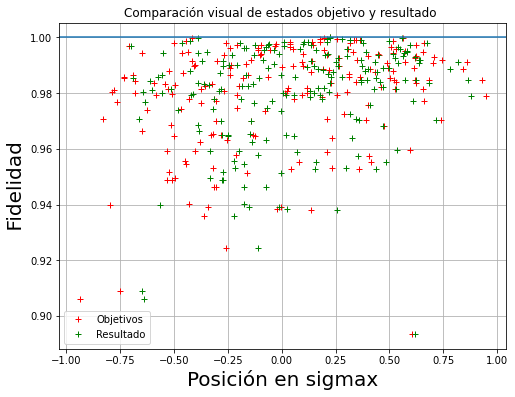

In [181]:
fig=plt.figure(figsize=(8, 6))
plt.plot(x_mix,n_fidels,'r+',label='Objetivos')
plt.plot(x_res,n_fidels,'g+',label='Resultado')
# plt.plot(z_mix,fidels,'b+',label='Sigmaz')
plt.axhline(1)
plt.xlabel("Posición en sigmax",size=20)
plt.legend()
plt.ylabel(" Fidelidad ",size=20)
plt.title("Comparación visual de estados yobjetivo y resultado ")
fig.savefig('x_comparacion.png')
plt.grid()

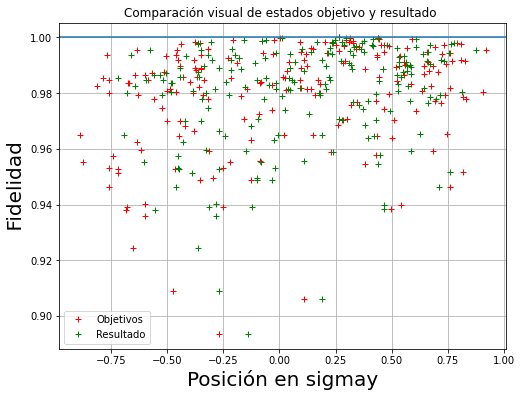

In [286]:
fig=plt.figure(figsize=(8, 6))
plt.plot(y_mix,n_fidels,'r+',label='Objetivos')
plt.plot(y_res,n_fidels,'g+',label='Resultado')
# plt.plot(z_mix,fidels,'b+',label='Sigmaz')
plt.axhline(1)
plt.xlabel("Posición en sigmay",size=20)
plt.legend()
plt.ylabel(" Fidelidad ",size=20)
plt.title("Comparación visual de estados objetivo y resultado ")
fig.savefig('y_comparacion.png')
plt.grid()

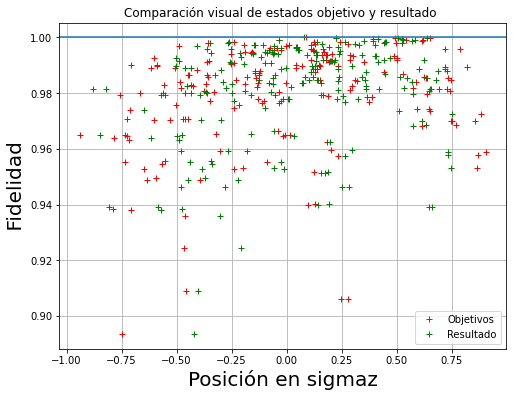

In [287]:
fig=plt.figure(figsize=(8, 6))
plt.plot(z_mix,n_fidels,'r+',label='Objetivos')
plt.plot(z_res,n_fidels,'g+',label='Resultado')
plt.axhline(1)
plt.xlabel("Posición en sigmaz",size=20)
plt.legend()
plt.ylabel(" Fidelidad ",size=20)
plt.title("Comparación visual de estados objetivo y resultado ")
fig.savefig('z_comparacion.png')
plt.grid()

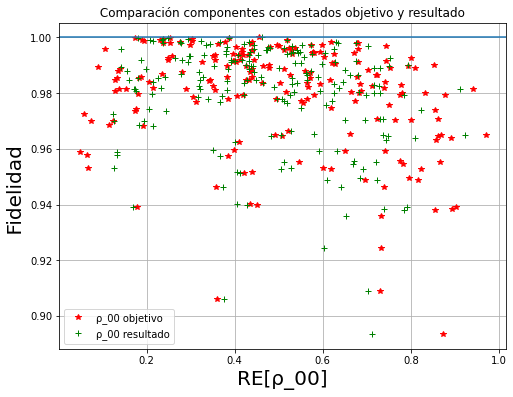

In [288]:
fig=plt.figure(figsize=(8, 6))
plt.plot(rho11_targ,n_fidels,'r*',label='ρ_00 objetivo')
plt.plot(rho11_res,n_fidels,'g+',label='ρ_00 resultado')
plt.axhline(1)
plt.xlabel("RE[ρ_00]",size=20)
plt.legend()
plt.ylabel(" Fidelidad  ",size=20)
plt.title(" Comparación componentes con estados objetivo y resultado ")
plt.savefig('rho00.png')
plt.grid()

In [247]:
print(np.where(n_fidels==np.amax(n_fidels)))
print(np.where(n_fidels==np.amin(n_fidels)))

(array([148]),)
(array([78]),)


In [248]:
max=rho_to_cartesian(aux02[148])
min=rho_to_cartesian(aux02[78])

max_res=rho_to_cartesian(aux2[148])
min_res=rho_to_cartesian(aux2[78])

colores=['FF1300','79FF00','FF1300','79FF00']

In [268]:
print("El estádo con máxima fidelidad: " + str(n_fidels[148]) + ", y  trace distance de: " +str( trace_dist(aux2[148],aux02[148])) + "presenta una pureza de: " + str(qi.purity(aux02[148]))  + "objetivo y " +str(qi.purity(aux2[148])) + " resultado"     )
print("El estádo con minima fidelidad: " + str(n_fidels[78]) + ", y  trace distance de: " +str( trace_dist(aux2[78],aux02[78])) + "presenta una pureza de: " + str(qi.purity(aux02[78]))  + "objetivo y " +str(qi.purity(aux2[78])) + " resultado")

El estádo con máxima fidelidad: 0.9999688737711518, y  trace distance de: 0.005539825963174949presenta una pureza de: (0.5640678700759404+0j)objetivo y (0.5628331111111109+0j) resultado
El estádo con minima fidelidad: 0.8935168963002672, y  trace distance de: 0.1740346228862258presenta una pureza de: (0.9955722531673832+0j)objetivo y (0.7912304444444448+0j) resultado


In [279]:
purities=[]
purities_res=[]
for i in range(len(fidels)):
    purities.append(qi.purity(aux02[i]))
    purities_res.append(qi.purity(aux2[i]))

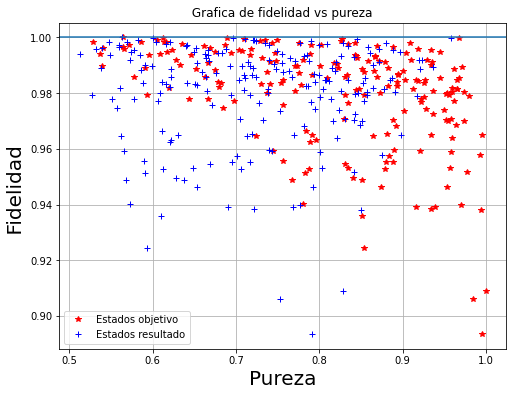

In [282]:
fig=plt.figure(figsize=(8, 6))
plt.plot(purities,n_fidels,'r*',label='Estados objetivo')
plt.plot(purities_res,n_fidels,'b+',label='Estados resultado')
plt.axhline(1)
plt.xlabel("Pureza",size=20)
plt.legend()
plt.ylabel(" Fidelidad  ",size=20)
plt.title(" Grafica de fidelidad vs pureza ")
plt.savefig('puritiesvsfidels.png')
plt.grid()

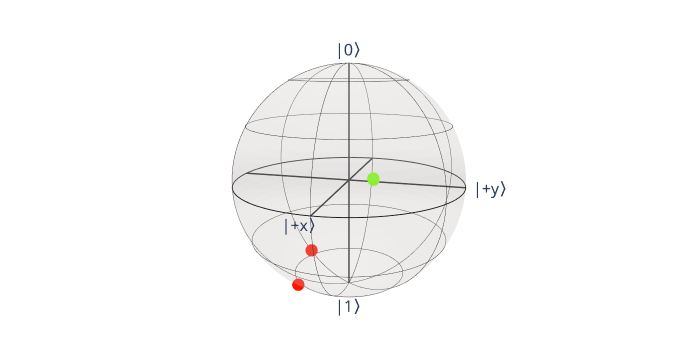

In [269]:
bloch_sphere( points=[min,max,min_res,max_res],points_color=colores )

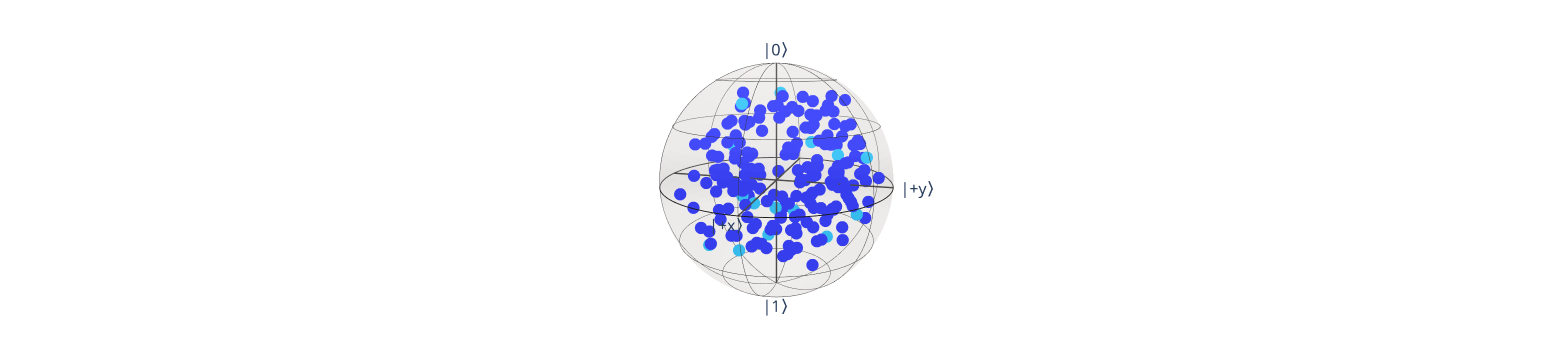

In [232]:
bloch_sphere(points=res,points_color=tarcol)

In [16]:
'''
Extracción de dataset con puros: 


    Basta con mover las condiciones iniciales para la extracción del dataset. La complejidad
    computacional no ha sido tomada aún para este proceso, por lo que se recomienda paciencia mas que todo
    y RAM. 
    

'''


##Con todo lo anterior es relativamente sencillo extraer un dataset, para ello abriremos archivos de texto:

#===================================================================================================

#Condiciones iniciales
num=50   #Número de datos a extraer
maxitr=60   #Número de iteraciones en cada minimización
qubits=1    # Número de qubits
layers=1     #Número de capas

#====================================================================================================

#Es posible realizar lo mismo en alguna computadora cuántica. 
provider = IBMQ.get_provider('ibm-q')
qcomp= provider.get_backend('ibmq_belem') 
#=====================================================================================================

#nombre de archivos de texto
targ_name='targetsp.npy'
results_name='resultsp.npy'
fidelity_name='fielitiesp.npy'
#=========================================================================================================

#Apertura de archivos de texto
f1 = open(targ_name, "w")
f2 = open(results_name,"w")
f3 = open(fidelity_name,"w")



#Proceso de guardado en archivo
targvals=0
densvals=0
fidels=0


target = qi.DensityMatrix(qi.random_statevector(2)).__array__()
targvals=target

dens,params=minimize(cost_func,maxitr)

densvals= state_tomo(3000,cirq_ansq(1,params,1)[0],1,1).__array__() 

fidels=qi.state_fidelity(qi.DensityMatrix(target),qi.DensityMatrix(densvals))


for i in range(0,num):
    print('Corrida numero'+str(i))
    
    target = qi.DensityMatrix(qi.random_statevector(2)).__array__()
    targvals= np.append(targvals,target)    
            
        
    
    dens,params=minimize(cost_func,maxitr)

    densvals= np.append(densvals,state_tomo(3000,cirq_ansq(1,params,1)[0],1,1).__array__())
    fidels = np.append(fidels,  qi.state_fidelity( qi.DensityMatrix(target) , state_tomo(3000,cirq_ansq(1,params,1)[0],1,1)) )


np.save(targ_name,targvals)
np.save(results_name,densvals)
np.save(fidelity_name,fidels)
f1.close()
f2.close()
f3.close()

Job Status: job has successfully run
Corrida numero0
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero1
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero2
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero3
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero4
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero5
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero6
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero7
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero8
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero9
Job Status: job has successfully run
Job Status: job has successfully run
Corrida numero10
Job Status: job has successfully run
Job Statu

In [25]:
# Con los datos mostrados se puede decir que 

In [23]:
#Carga de archivos
fidelsp=np.load('fielitiesp.npy')
targvalsp=np.load('targetsp.npy')
densvalsp=np.load('resultsp.npy')

In [55]:
#Asignación de colores para fidelidad
tar=[]
tarcol=[]
res=[]
rescol=[]

for i in range(0,204,4):
    tar.append(al.rho_to_cartesian((np.reshape(targvalsp[i:i+4],(2,2)))) )
    res.append(al.rho_to_cartesian((np.reshape(densvalsp[i:i+4],(2,2)))) )

for i in range(0,51):
    if fidelsp[i]<=0.5:
        tarcol.append('ff0612')
    elif fidelsp[i]<=0.6 and  fidelsp[i]>0.5 :
        tarcol.append('ff7200')
    elif fidelsp[i]<=0.7 and  fidelsp[i]>0.6 :
        tarcol.append('ffcc00')
    elif fidelsp[i]<=0.8 and  fidelsp[i]>0.7 :
        tarcol.append('9cff00')
    elif fidelsp[i]<=0.9 and  fidelsp[i]>0.8 :
        tarcol.append('00ffba')
    elif fidelsp[i]<=0.95 and  fidelsp[i]>0.9 :
        tarcol.append('00baff')
    elif fidelsp[i]<=1.00 and  fidelsp[i]>0.95 :
        tarcol.append('000cff')

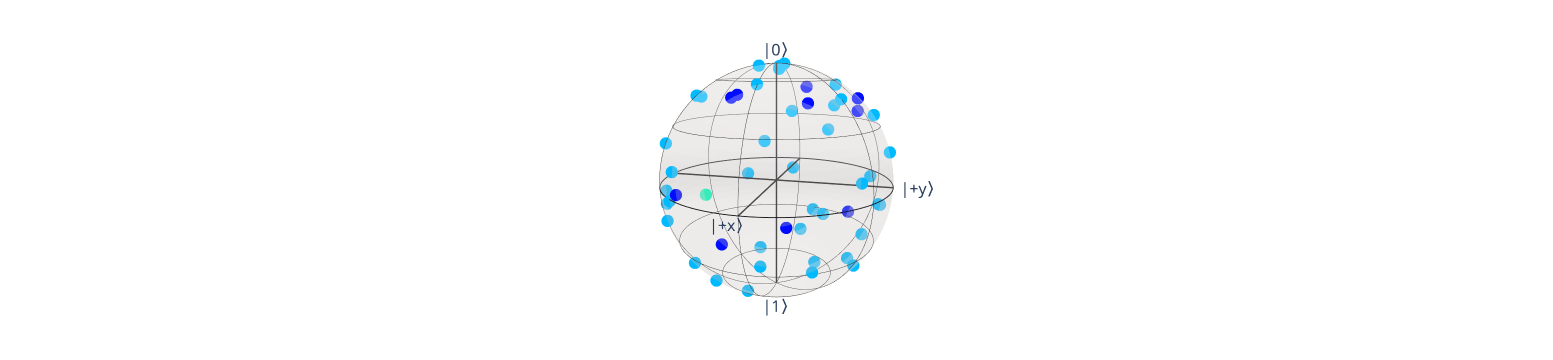

In [56]:
bloch_sphere( points=tar,points_color=tarcol )

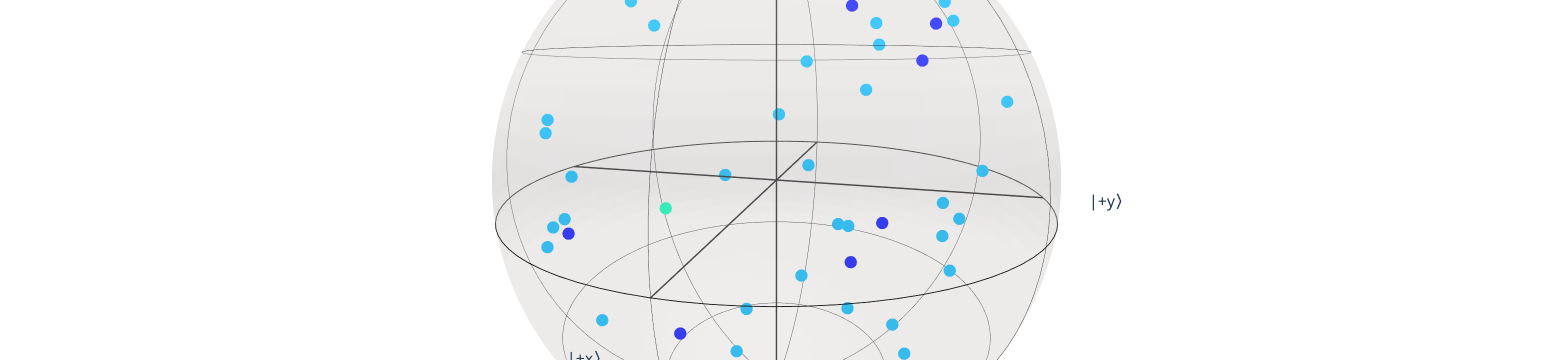

In [57]:
bloch_sphere(points=res,points_color=tarcol)

In [58]:
print("La media de fidelidades los estados puros generados es de " + str(np.mean(fidelsp)) + " con un error de " + str(np.std(fidelsp) ))

La media de fidelidades los estados puros generados es de 0.935604889973921 con un error de 0.02224154616415414


Los resultados mostraron entonces para una muestra de 100 estados mixtos purezas de $0.980 \pm  0.020$.
$\\$
Mientras que con una muestra de 50 estados puros purezas de $ 0.935 \pm 0.022$


# Comparación entre éste método y circuitos triviales de estados mixtos/puros: 

## Estado Máximamente Mixto

In [39]:
target=[[0.5,0],[0,0.5]]
#Forma trivial
mixes=QuantumCircuit(2)
mixes.h(0)
mixes.cx(0,1)


#Generador de estados aleatorios
qubits=1 
capas=1  
target= [[0.5,0],[0,0.5]]
cost_por_iteracion=[] #Se resetea el vector de iteraciones
maxitr=50  #Número máximo de iteraciones

result=minimize(cost_func,maxitr)

In [40]:
#Es posible realizar lo mismo en alguna computadora cuántica. 
provider = IBMQ.get_provider('ibm-q')
qcomp= provider.get_backend('ibmq_belem') 

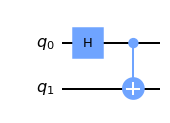

In [41]:
mixes.draw()

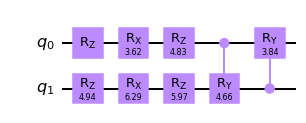

In [42]:
cirq_ansq(1,result[1],1)[0].draw()

In [44]:
densforma1=state_tomo(5000,cirq_ansq(1,result[1],1)[0],1,server=1)

Job Status: job is queued (85)    

KeyboardInterrupt: 

In [ ]:
denstriv=state_tomo(5000,mixes,1,server=1)

In [ ]:
densforma1.draw('latex')

In [ ]:
denstriv.draw('latex')

In [44]:
qi.state_fidelity(target,denstriv)

0.9972894931526305

In [45]:
qi.state_fidelity(target,densforma1)

0.999212419717298